In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score,accuracy_score,log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging
import pandas as pd
from typing import Tuple 
from torch import nn
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random
from typing import List, Set
from torch import cuda
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import precision_recall_curve, f1_score, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

ROUTE_BINARIZED_NAICS= '../../data/coverwallet/df_binarized_naics.csv' 
df_binarized_naics= pd.read_csv(ROUTE_BINARIZED_NAICS)

print(df_binarized_naics.head(1))

/home/oscar/.cache/pypoetry/virtualenvs/zrive-ds-JAc9gx7h-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                BUSINESS_DESCRIPTION  11  21  22  23  31  32  \
0  Zenyai Viet Cajun & Pho Restaurant is dedicate...   0   0   0   0   0   0   

   33  42  44  ...  53  54  55  56  61  62  71  72  81  92  
0   0   0   0  ...   0   0   0   0   0   0   0   1   0   0  

[1 rows x 25 columns]


**Dataframe generation**

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = dataframe['BUSINESS_DESCRIPTION'].astype(str).tolist()
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Los códigos NAICS están representados por las columnas excepto 'BUSINESS_DESCRIPTION'
        self.naics_columns = dataframe.columns[1:].tolist()
        self.labels = dataframe[self.naics_columns].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Obtener solo el primer token (CLS token)
        
        label = self.labels[idx]  # Los labels ya son un array binario para cada fila
        
        return {
            'embeddings': embeddings.squeeze().detach().cpu().numpy(),
            'labels': label
        }

    def create_dataframe(self):
        data = []
        for i in range(len(self)):
            item = self[i]
            row = {'embeddings': item['embeddings']}
            row.update({naics: int(label) for naics, label in zip(self.naics_columns, item['labels'])})
            data.append(row)
        df_embeddings = pd.DataFrame(data)
        logging.info(f"DataFrame created: \n{df_embeddings.head()}")
        return df_embeddings

dataset = CustomDataset(dataframe=df_binarized_naics, max_len=128)

df_embeddings = dataset.create_dataframe()
print(df_embeddings.head(1))

                                          embeddings  11  21  22  23  31  32  \
0  [-0.31724116, 0.04700651, -0.050650183, -0.176...   0   0   0   0   0   0   
1  [-0.17782614, 0.014079615, -0.3276313, -0.2718...   0   0   0   0   0   0   
2  [-0.36865684, -0.24259493, 0.27092156, -0.2226...   0   0   0   0   0   0   
3  [0.046412002, 0.21785533, -0.18463011, -0.0978...   0   0   0   0   0   0   
4  [-0.11654073, 0.124375336, -0.102831736, -0.07...   0   0   0   0   0   0   

   33  42  44  ...  53  54  55  56  61  62  71  72  81  92  
0   0   0   0  ...   0   0   0   0   0   0   0   1   0   0  
1   0   0   0  ...   0   1   0   0   0   0   0   0   0   0  
2   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   0   0   0  ...   0   0   0   0   0   1   0   0   0   0  

[5 rows x 25 columns]


In [2]:
ROUTE_EMBEDDINGS = '../../data/df_embeddings.csv' 
df_embeddings= pd.read_csv(ROUTE_EMBEDDINGS)

In [18]:
def load_and_convert_embeddings(embeddings_str):
    cleaned_embeddings_str = embeddings_str.replace('[', '').replace(']', '').replace('\n', '')

    embeddings_list = [float(num_str) for num_str in cleaned_embeddings_str.split()]

    embeddings_array = np.array(embeddings_list)
    
    return embeddings_array

df_embeddings['embeddings'] = df_embeddings['embeddings'].apply(load_and_convert_embeddings)

In [50]:
classes = df_embeddings.columns[1:]

In [ ]:
columns_to_convert = df_embeddings.columns[df_embeddings.columns != 'embeddings']
df_embeddings[columns_to_convert] = (df_embeddings[columns_to_convert] != 0).astype(int)

In [40]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
df_training, df_val = train_test_split(df_embeddings, test_size=0.2, random_state=42)

X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training.drop('embeddings', axis=1).to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val.drop('embeddings', axis=1).to_numpy()

**Logistic regression**

In [47]:
classifiers = []

for column in range(y_train.shape[1]):
    target = y_train[:,column]
    
    logistic_clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    logistic_clf.fit(X_train, target)

    classifiers.append(logistic_clf)

clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico


In [48]:
predictions_val = []
predictions_proba_val = []

for clf in classifiers:
    y_pred_class = clf.predict(X_val)
    y_proba_class = clf.predict_proba(X_val)[:,1]
    predictions_val.append(y_pred_class)
    predictions_proba_val.append(y_proba_class)

predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo
predigo


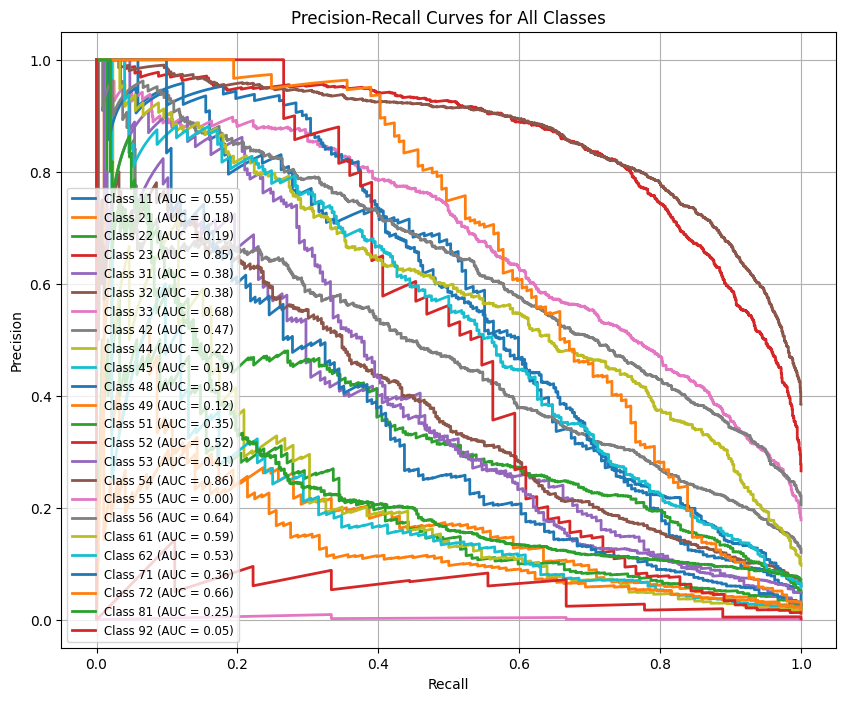


F1-scores for all classes:
Class 11: 0.53
Class 21: 0.15
Class 22: 0.10
Class 23: 0.78
Class 31: 0.33
Class 32: 0.31
Class 33: 0.59
Class 42: 0.39
Class 44: 0.14
Class 45: 0.18
Class 48: 0.51
Class 49: 0.08
Class 51: 0.25
Class 52: 0.51
Class 53: 0.37
Class 54: 0.78
Class 55: 0.00
Class 56: 0.53
Class 61: 0.48
Class 62: 0.47
Class 71: 0.29
Class 72: 0.58
Class 81: 0.14
Class 92: 0.00


In [60]:
plt.figure(figsize=(10, 8))

f1_scores = []

for column in range(y_train.shape[1]):
    label = classes[column]
    y_true_class = y_val[:, column]
    clf = classifiers[column]
    y_scores = clf.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_true_class, y_scores)
    auc_score = auc(recall, precision)

    f1 = f1_score(y_true_class, (y_scores > 0.5).astype(int))  # Usamos umbral de 0.5 para la clasificación binaria

    f1_scores.append(f1)

    plt.plot(recall, precision, lw=2, label=f'Class {label} (AUC = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Classes')
plt.legend()
plt.grid(True)

plt.legend(loc='lower left', fontsize='small')

plt.show()
print("\nF1-scores for all classes:")
for i, label in enumerate(classes):
    print(f"Class {label}: {f1_scores[i]:.2f}")

**Random Forest**

In [62]:
classifiers = []

for column in range(y_train.shape[1]):
    target = y_train[:,column]
    
    RF_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    RF_clf.fit(X_train, target)

    classifiers.append(RF_clf)
    print("clasifico")

clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico
clasifico


In [64]:
predictions_val = []
predictions_proba_val = []

for clf in classifiers:
    y_pred_class = clf.predict(X_val)
    y_proba_class = clf.predict_proba(X_val)[:,1]
    predictions_val.append(y_pred_class)
    predictions_proba_val.append(y_proba_class)

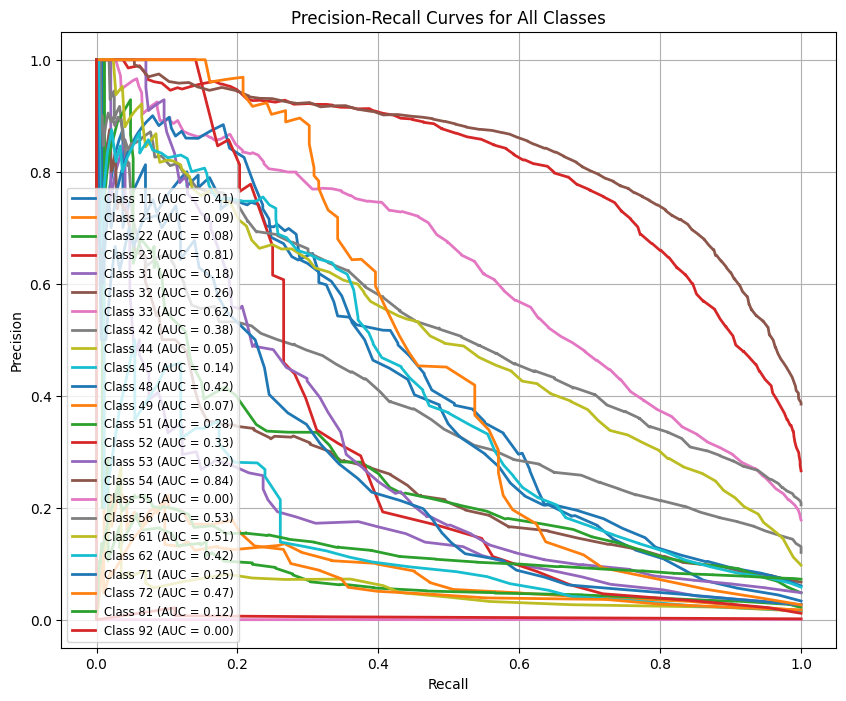


F1-scores for all classes:
Class 11: 0.21
Class 21: 0.02
Class 22: 0.02
Class 23: 0.67
Class 31: 0.04
Class 32: 0.02
Class 33: 0.42
Class 42: 0.09
Class 44: 0.00
Class 45: 0.02
Class 48: 0.12
Class 49: 0.00
Class 51: 0.03
Class 52: 0.12
Class 53: 0.10
Class 54: 0.74
Class 55: 0.00
Class 56: 0.19
Class 61: 0.25
Class 62: 0.21
Class 71: 0.03
Class 72: 0.31
Class 81: 0.00
Class 92: 0.00


In [65]:
plt.figure(figsize=(10, 8))

f1_scores = []

for column in range(y_train.shape[1]):
    label = classes[column]
    y_true_class = y_val[:, column]
    clf = classifiers[column]
    y_scores = clf.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_true_class, y_scores)
    auc_score = auc(recall, precision)

    f1 = f1_score(y_true_class, (y_scores > 0.5).astype(int))  # Usamos umbral de 0.5 para la clasificación binaria

    f1_scores.append(f1)

    plt.plot(recall, precision, lw=2, label=f'Class {label} (AUC = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Classes')
plt.legend()
plt.grid(True)

plt.legend(loc='lower left', fontsize='small')

plt.show()
print("\nF1-scores for all classes:")
for i, label in enumerate(classes):
    print(f"Class {label}: {f1_scores[i]:.2f}")